# 10. Logistic Regression

## 10.5 Bayesian logistic regression

### 10.5.1 Laplace approximation

> Author: Meduri Venkata Shivaditya

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Creating data
N = 30
D = 2

N_zeros = np.zeros(N)
N_ones = np.ones(N)

mu1 = np.stack((N_ones, 5 * N_ones), axis=1)  # shape (N, D)
mu2 = np.stack((-5 * N_ones, N_ones), axis=1) # shape (N, D)

std1 = 1
std2 = 1.1

rng = np.random.default_rng(seed=12)
X1 = std1 * rng.standard_normal((N, D)) + mu1
X2 = 2 * std2 * rng.standard_normal((N, D)) + mu2

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((N_ones, N_zeros), axis=0)
X.shape, y.shape

((60, 2), (60,))

#### Figure 10.13: (a) Illustration of the data. (b) Log-likelihood for a logistic regression model. The line is drawn from the origin in the direction of the MLE (which is at infinity).

The posterior $p(w|\mathcal{D})\propto p(\mathcal{D}|w)p(w)$, where the prior $p(w)=\mathcal{N}(w|0, 10^2I)$
and the log-likelihood $\log p(\mathcal{D}|w)$ is given by
$$
\begin{align*}
\operatorname{LL}(w) &= \log p(\mathcal{D}|w) = \log\prod_n\operatorname{Ber}(y_n|\sigma(w^Tx_n)) \\
&= \sum_n \bigl[ y_n\log\sigma(w^Tx_n)-(1-y_n)\log\sigma(-w^Tx_n) \bigr] \\
&= \sum_n y_n(w^Tx_n) - \sum_n\log(1+\exp(w^Tx_n))
\end{align*}
$$

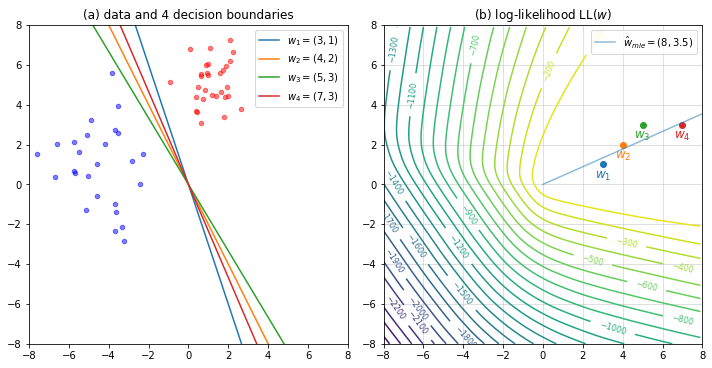

In [75]:
weights = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])

xs = np.arange(-8, 8, 0.1)
xx, yy = np.meshgrid(xs, xs)

W = np.stack((xx.ravel(), yy.ravel()), axis=1)
log_likelihood = np.dot(W @ X.T, y) - np.sum(np.log(1 + np.exp(W @ X.T)), axis=1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (a) Plotting data

ax1.scatter(*X[y == 1].T, s=20, marker='o', color='red', alpha=0.5)
ax1.scatter(*X[y == 0].T, s=20, marker='o', color='blue', alpha=0.5)
for i, w in enumerate(weights):
    # decision boundary = -w[0] / w[1] = -b / w
    ax1.plot(xs, -xs * w[0] / w[1], label=f'$w_{i+1}=({w[0]},{w[1]})$')

ax1.set_xlim([-8, 8])
ax1.set_ylim([-8, 8])
ax1.set_aspect('equal')
ax1.set_title('(a) data and 4 decision boundaries')
ax1.legend()

# (b) Plotting log-likelihood
cs = ax2.contour(xx, yy, log_likelihood.reshape(xx.shape), levels=30)
ax2.clabel(cs, inline=True, fontsize=8)
for i, w in enumerate(weights):
    ax2.plot(w[0], w[1], marker='o', color=f'C{i}')
    ax2.text(w[0], w[1]-0.25, f'$w_{i+1}$', color=f'C{i}', ha='center', va='top', fontsize=12)

w_mle = W[np.argmax(log_likelihood)]
#ax2.axline((w_mle[0], w_mle[1]), slope=w_mle[1] / w_mle[0], alpha=0.5)
ax2.plot(
    (0, 8), (0, 8 * w_mle[1] / w_mle[0]), alpha=0.5,
    label=f'$\hat w_{{mle}}=(8, {8 * w_mle[1] / w_mle[0]:.1f})$'
)

ax2.set_xlim([-8, 8])
ax2.set_ylim([-8, 8])
ax2.set_aspect('equal')
ax2.set_title('(b) log-likelihood $\operatorname{LL}(w)$')
ax2.grid(True)
ax2.legend()

# fig.colorbar(cs, ax=ax2)
fig.tight_layout()


#### Figure 10.13: (c) Unnormalized log posterior (assuming vague spherical prior). (d) Laplace approximation to posterior.

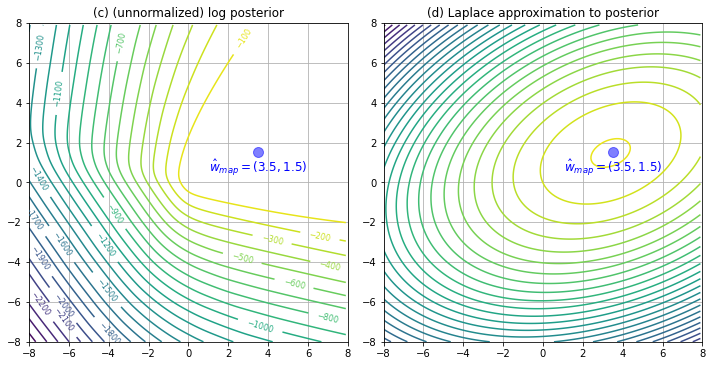

In [100]:
from scipy.stats import multivariate_normal
alpha = 100
log_prior = np.log(multivariate_normal.pdf(W, cov=np.identity(D) * alpha))
log_joint = log_likelihood + log_prior

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (c) Plotting the (unnormalised) log posterior

cs = ax1.contour(xx, yy, log_joint.reshape(xx.shape), levels=30)
ax1.clabel(cs, inline=True, fontsize=8)

w_map = W[np.argmax(log_joint)]
ax1.plot(
    w_map[0], w_map[1], marker='o', markersize=10, color='blue', alpha=0.5
)
ax1.text(
    w_map[0], w_map[1]-0.25, f'$\hat w_{{map}}=({w_map[0]:.1f}, {w_map[1]:.1f})$',
    color='blue', ha='center', va='top', fontsize=12
)

ax1.set_xlim([-8, 8])
ax1.set_ylim([-8, 8])
ax1.set_aspect('equal')
ax1.set_title('(c) (unnormalized) log posterior')
ax1.grid(True)

# (d) Plotting the Laplace approximation to posterior

# https://bayes-logistic.readthedocs.io/en/latest/usage.html
# Visit the website above to access the source code of bayes_logistic library
# parameter info : bayes_logistic.fit_bayes_logistic(y, X, wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=100)
from bayes_logistic import fit_bayes_logistic
wfit, hfit = fit_bayes_logistic(
    y.reshape(N * D),
    X,
    np.zeros(D),
    ((np.identity(D)) * 1 / alpha),
    weights=None,
    solver='Newton-CG',
    bounds=None,
    maxiter=100,
)
# wfit represents the posterior parameters (MAP estimate)
# hfit represents the posterior Hessian  (Hessian of negative log posterior evaluated at MAP parameters)
log_laplace_posterior = np.log(multivariate_normal.pdf(W, mean=wfit, cov=np.linalg.inv(hfit)))

cs = ax2.contour(xx, yy, log_laplace_posterior.reshape(xx.shape), levels=30)
# ax2.clabel(cs, inline=True, fontsize=8)
ax2.plot(
    w_map[0], w_map[1], marker='o', markersize=10, color='blue', alpha=0.5
)
ax2.text(
    w_map[0], w_map[1]-0.25, f'$\hat w_{{map}}=({w_map[0]:.1f}, {w_map[1]:.1f})$',
    color='blue', ha='center', va='top', fontsize=12
)

ax2.set_xlim([-8, 8])
ax2.set_ylim([-8, 8])
ax2.set_aspect('equal')
ax2.set_title('(d) Laplace approximation to posterior')
ax2.grid(True)

fig.tight_layout()

In [ ]:
# Author: Meduri Venkata Shivaditya


from scipy.stats import norm, multivariate_normal

try:
    import bayes_logistic  # pip install -qq bayes_logistic
except ModuleNotFoundError:
    %pip install -qq bayes_logistic
    import bayes_logistic  # pip install -qq bayes_logistic
import warnings

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

warnings.filterwarnings("ignore", category=RuntimeWarning)


np.random.seed(135)
# Creating data
N = 30
D = 2
mu1 = np.hstack((np.ones((N, 1)), 5 * np.ones((N, 1))))
mu2 = np.hstack((-5 * np.ones((N, 1)), np.ones((N, 1))))
class1_std = 1
class2_std = 1.1
X_1 = np.add(class1_std * np.random.randn(N, 2), mu1)
X_2 = np.add(2 * class2_std * np.random.randn(N, 2), mu2)
X = np.vstack((X_1, X_2))
t = np.vstack((np.ones((N, 1)), np.zeros((N, 1))))

# Plotting data
x_1, y_1 = X[np.where(t == 1)[0]].T
x_2, y_2 = X[np.where(t == 0)[0]].T
plt.figure(0)
plt.scatter(x_1, y_1, c="red", s=20, marker="o")
plt.scatter(x_2, y_2, c="blue", s=20, marker="o")

# Plotting Predictions
alpha = 100
Range = 8
step = 0.1
xx, yy = np.meshgrid(np.arange(-Range, Range, step), np.arange(-Range, Range, step))
[n, n] = xx.shape
W = np.hstack((xx.reshape((n * n, 1)), yy.reshape((n * n, 1))))
Xgrid = W
ws = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])
col = ["black", "red", "green", "blue"]
for ii in range(ws.shape[0]):
    w = ws[ii][:]
    pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, w)))
    plt.contour(xx, yy, pred.reshape((n, n)), 1, colors=col[ii])
plt.title("data")
pml.savefig("logreg_laplace_data.pdf", dpi=300)


# Plot prior, likelihood, posterior

Xt = np.transpose(X)
f = np.dot(W, Xt)
log_prior = np.log(multivariate_normal.pdf(W, cov=(np.identity(D)) * alpha))

log_like = np.dot(np.dot(W, Xt), t) - np.sum(np.log(1 + np.exp(f)), 1).reshape((n * n, 1))
log_joint = log_like.reshape((n * n, 1)) + log_prior.reshape((n * n, 1))

# Plotting log-prior
# plt.figure(1)
# plt.contour(xx, yy, -1*log_prior.reshape((n,n)), 30)
# plt.title("Log-Prior")

plt.figure(1)
plt.contour(xx, yy, -1 * log_like.reshape((n, n)), 30)
plt.title("Log-Likelihood")

# Plotting points corresponding to chosen lines
for ii in range(0, ws.shape[0]):
    w = np.transpose(ws[ii, :])
    plt.annotate(str(ii + 1), xy=(w[0], w[1]), color=col[ii])

j = np.argmax(log_like)
wmle = W[j, :]
slope = wmle[1] / wmle[0]
# plt.axline([wmle[0], wmle[1]], slope=slope)

plt.plot([0, 7.9], [0, 7.9 * slope])
plt.grid()
pml.savefig("logreg_laplace_logLik.pdf", dpi=300)


# Plotting the log posterior(Unnormalised
plt.figure(2)
plt.contour(xx, yy, -1 * log_joint.reshape((n, n)), 30)
plt.title("Log-Unnormalised Posterior")
j2 = np.argmax(log_joint)
wb = W[j2][:]
plt.scatter(wb[0], wb[1], c="red", s=100)
plt.grid()
pml.savefig("logreg_laplace_unnormalised_posterior.pdf", dpi=300)

# Plotting the Laplace approximation to posterior
plt.figure(3)
# https://bayes-logistic.readthedocs.io/en/latest/usage.html
# Visit the website above to access the source code of bayes_logistic library
# parameter info : bayes_logistic.fit_bayes_logistic(y, X, wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=100)
wfit, hfit = bayes_logistic.fit_bayes_logistic(
    t.reshape((N * D)),
    X,
    np.zeros(D),
    ((np.identity(D)) * 1 / alpha),
    weights=None,
    solver="Newton-CG",
    bounds=None,
    maxiter=100,
)
co = np.linalg.inv(hfit)
# wfit represents the posterior parameters (MAP estimate)
# hfit represents the posterior Hessian  (Hessian of negative log posterior evaluated at MAP parameters)
log_laplace_posterior = np.log(multivariate_normal.pdf(W, mean=wfit, cov=co))
plt.contour(xx, yy, -1 * log_laplace_posterior.reshape((n, n)), 30)
plt.scatter(wb[0], wb[1], c="red", s=100)
plt.title("Laplace Approximation to Posterior")
plt.grid()
pml.savefig("logreg_laplace_posterior.pdf", dpi=300)


# Plotting the predictive distribution for logistic regression
plt.figure(5)
pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, wfit)))
plt.contour(xx, yy, pred.reshape((n, n)), 30)
x_1, y_1 = X[np.where(t == 1)[0]].T
x_2, y_2 = X[np.where(t == 0)[0]].T
plt.scatter(x_1, y_1, c="red", s=20, marker="o")
plt.scatter(x_2, y_2, c="blue", s=40, marker="o")
plt.title("p(y=1|x, wMAP)")
pml.savefig("logreg_laplace_prediction_plugin.pdf", dpi=300)

# Decision boundary for sampled w
plt.figure(6)
plt.scatter(x_1, y_1, c="red", s=20, marker="o")
plt.scatter(x_2, y_2, c="blue", s=20, marker="o")
predm = np.zeros((n * n, 1))
s = 100
for i in range(s):
    wsamp = np.random.multivariate_normal(mean=wfit, cov=co)
    pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, wsamp)))
    predm = np.add(predm, pred.reshape((n * n, 1)))
    plt.contour(xx, yy, pred.reshape((n, n)), np.array([0.5]))
plt.title("Decision boundary for sampled w")
pml.savefig("logreg_laplace_prediction_samples.pdf", dpi=300)

# MC
plt.figure(7)
predm = predm / s
plt.contour(xx, yy, predm.reshape((n, n)), 30)
plt.scatter(x_1, y_1, c="red", s=20, marker="o")
plt.scatter(x_2, y_2, c="blue", s=20, marker="o")
plt.title("MC approx of p(y=1|x)")
pml.savefig("logreg_laplace_prediction_mc.pdf", dpi=300)

# Numerical
plt.figure(8)
plt.scatter(x_1, y_1, c="red", s=20, marker="o")
plt.scatter(x_2, y_2, c="blue", s=20, marker="o")
pr = bayes_logistic.bayes_logistic_prob(Xgrid, wfit, hfit)
plt.contour(xx, yy, pr.reshape((n, n)), 30)
plt.title("Deterministic approx of p(y=1|x)")
pml.savefig("logreg_laplace_prediction_probit.pdf", dpi=300)

plt.show()